# **Final Project**

### Tracy Truong and Deniz Ibrahimzade

For this project, we will be analyzing Gillian Flynn's 2012 mystery/thriller novel, *Gone Girl*, through lenses of close and distant reading.

In [1]:
# project imports
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import Counter
from afinn import Afinn
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# load spacy english language model
ner = spacy.load("en_core_web_sm")

This project leverages and expands on code from the existing project detailed in [Thu Vu data analytics](https://www.youtube.com/watch?v=fAHkJ_Dhr50)' video tutorial on creating a simple character network for *The Witcher*.

## *Gone Girl*

In order to develop character networks that can help us understand *Gone Girl* better, we will be processing the three parts of the novel - Boy Loses Girl, Boy Meets Girl, Boy Gets Girl Back - separately.

### Boy Loses Girl

#### Extracting Character Entities Using Name Entity Recognition

To begin the process of breaking down the novel in order to generate useful data for character analysis, we will first run the text through spaCy's Name Entity Recognition model.

In [2]:
# load the first part of the book and run name entity recognition on it
gg1_book = (r"C:\Users\tracypaige\LTCS180\txt_gillian_flynn\gone_girl_part1.txt")
gg1_text = open(gg1_book, encoding="utf8").read()
gg1_doc = ner(gg1_text)

In [3]:
# preview of the ner results
displacy.render(gg1_doc[0:766], style="ent", jupyter=True)

Because we are primarily interested in the character entities for our eventual construction of character networks, we want to run through the text to extract co-occurance data. This will require us to filter out character entities on a sentence-level granularity.

Before we do this, however, we will extract a character list using BookNLP's model for extracting character data. This will help us in the filtering process described above.

In [4]:
# functions for extracting novel information
# note: leveraged from the BookNLP documentation
def proc(filename):
    with open(filename) as file:
        data=json.load(file)
    return data

def get_counter_from_dependency_list(dep_list):
    counter=Counter()
    for token in dep_list:
        term=token["w"]
        tokenGlobalIndex=token["i"]
        counter[term]+=1
    return counter

# function for extracting character information
# note: leveraged from the BookNLP documentation
def create_character_data(data, printTop):
    character_data = {}
    for character in data["characters"]:

        agentList=character["agent"]
        patientList=character["patient"]
        possList=character["poss"]
        modList=character["mod"]

        character_id=character["id"]
        count=character["count"]

        referential_gender_distribution=referential_gender_prediction="unknown"

        if character["g"] is not None and character["g"] != "unknown":
            referential_gender_distribution=character["g"]["inference"]
            referential_gender=character["g"]["argmax"]

        mentions=character["mentions"]
        proper_mentions=mentions["proper"]
        max_proper_mention=""

        # create some empty lists we can append to
        poss_items = []
        agent_items = []
        patient_items = []
        mod_items = []
        
        # just print out information about named characters
        if len(mentions["proper"]) > 0:
            max_proper_mention=mentions["proper"][0]["n"]
            for k, v in get_counter_from_dependency_list(possList).most_common(printTop):
                poss_items.append((v,k))
            for k, v in get_counter_from_dependency_list(agentList).most_common(printTop):
                agent_items.append((v,k))
            for k, v in get_counter_from_dependency_list(patientList).most_common(printTop):
                patient_items.append((v,k))
            for k, v in get_counter_from_dependency_list(modList).most_common(printTop):
                mod_items.append((v,k))
        
            # print(character_id, count, max_proper_mention, referential_gender)
            character_data[character_id] = {"name": max_proper_mention,
                                            "id": character_id,
                                            "timesMentioned": count,
                                            "gender": referential_gender,
                                            "possList": poss_items,
                                            "agentList": agent_items,
                                            "patientList": patient_items,
                                            "modList": mod_items}
    
    return character_data

In [5]:
# utilize above functions to produce a list of characters in Gone Girl
gone_girl_data = proc(r"C:\Users\tracypaige\LTCS180\bookNLP_gillian_flynn\gone_girl\gone_girl.book")
gone_girl_character_data = create_character_data(gone_girl_data, 50)
gone_girl_characters_df = pd.DataFrame(gone_girl_character_data).T.reset_index(drop=True)[['name']]
# lowercase the names for uniformity for future processing
gone_girl_characters_df['name'] = gone_girl_characters_df['name'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [6]:
# remove rows with duplicates
gone_girl_characters_df = gone_girl_characters_df.drop_duplicates()
# take a look at the character list
pd.set_option('display.max_rows', None)
gone_girl_characters_df

,name
0,amy
1,nick
2,go
3,desi
4,boney
5,andie
6,tanner
7,rand
8,gilpin
9,greta


Although most of the characters seem to have processed correctly, we will manually go through them to ensure that the list is accurate. This is important because we want our character network to be as precise as possible, as the accuracy of the character nodes is contingent on the accuracy of the character list.

In [7]:
# manually remove inaccurate entries
gone_girl_characters_df = gone_girl_characters_df.drop([25, 27, 28, 39, 41, 44, 47, 50, 53, 55,
                                                        56, 60, 61, 64, 69, 75, 76, 77, 79, 80,
                                                        81, 82, 83, 84, 85, 86, 87, 88, 91, 93,
                                                        94, 97, 99, 101, 102, 103, 105, 106, 107, 110,
                                                        113, 114, 116, 118, 119, 120, 121, 123, 125, 126,
                                                        127, 129, 130, 132, 133, 134, 136, 137, 139, 140, 141])

# reset index and look at updated character list
gone_girl_characters_df = gone_girl_characters_df.reset_index()
gone_girl_characters_df.head(20)

,index,name
0,0,amy
1,1,nick
2,2,go
3,3,desi
4,4,boney
5,5,andie
6,6,tanner
7,7,rand
8,8,gilpin
9,9,greta


Now, we can run through the text and extract the character entities by comparing the results of the NER model against the names in the character list we've just generated.

In [8]:
gg1_char_entity_df = []

# loop through sentences, filter and store character entity list for each sentence
for sent in gg1_doc.sents:
    # make sure to filter differences by converting to lowercase
    char_entity_list = [ent.text.lower() for ent in sent.ents
                        if ent.text.lower() in list(gone_girl_characters_df['name'])]
    gg1_char_entity_df.append({"sentence": sent, "char_entities": char_entity_list})

# convert list of data into dataframe
gg1_char_entity_df = pd.DataFrame(gg1_char_entity_df)

# remove sentences without character entities
gg1_char_entity_df = gg1_char_entity_df[gg1_char_entity_df['char_entities'].map(len) > 0]

In [9]:
# let's take a look at the dataframe so far
gg1_char_entity_df.head(20)

,sentence,char_entities
1,"(Tony, Kushner, ,, THE, ILLUSION, \n\n\n\n\n\n...",[nick]
13,"(What, are, you, thinking, ,, Amy, ?)",[amy]
40,"(It, had, been, a, compromise, :, Amy, demande...",[amy]
42,"(It, was, a, compromise, ,, but, Amy, did, n’t...",[amy]
43,"(To, Amy, ,, it, was, a, punishing, whim, on, ...",[amy]
47,"(Amy, ,, usually, ., \n\n, Do, not, blame, me,...","[amy, amy]"
62,"(Three, weeks, after, I, got, cut, loose, ,, A...",[amy]
63,"((, Now, I, can, feel, Amy, looking, over, my,...",[amy]
65,"(Just, like, Nick, ,, she, would, say, .)",[nick]
66,"(It, was, a, refrain, of, hers, :, Just, like,...",[nick]


#### Character Network

Now that we have the data for character entities per sentence, we can build the co-occurence and character sentiment dataframe to use for constructing the character network. We will be examining the co-occurence within every three sentences in the text, and will denote detected relationships with a source and target. Additionally, we will be examining the sentiment relationship between these detected relationships.

In [25]:
def create_char_relationships(char_entity_df):
    afinn = Afinn()
    relationships = []

    # loop through the sentence window (3 sentences)
    for i in range(char_entity_df.index[-1]):
        
        end_i = min(i+3, char_entity_df.index[-1])
        char_list = sum((char_entity_df.iloc[i: end_i].char_entities), [])
        
        # compute average sentiment score for this sentence window
        score = 0
        for j in range(i, end_i):
            score = score + afinn.score(str(char_entity_df['sentence'].iloc[j]))
        score = score / (end_i - 1)

        # remove duplicate characters so that we don't produce relationships between the same character
        char_unique = [char_list[j] for j in range(len(char_list)) 
            if (j==0) or char_list[j] != char_list[j-1]]
        char_unique.sort()
        
        # if there is more than character in the window (don't consider relationships between the same character)
        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b, "sentiment_score": score})
                
                
    # return the relationship list
    return relationships

In [155]:
# create a relationship dataframe and print preview of results
gg1_relationship_df = pd.DataFrame(create_char_relationships(gg1_char_entity_df.reset_index()))

# assign values based on number of relationships
gg1_relationship_df["num_cooccurence"] = 1
gg1_relationship_df = gg1_relationship_df.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg1_relationship_df = gg1_relationship_df.loc[gg1_relationship_df['source'] != gg1_relationship_df['target']] 

# take a look at the character relationship dataframe
gg1_relationship_df.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,nick,-0.011595,121
1,amy,carmen,0.291538,2
2,carmen,nick,0.195197,2
3,alice,amy,0.024390,3
5,amy,carl,0.008045,13
7,amy,bleecker,0.029242,7
8,bleecker,carl,0.060334,4
10,amy,marybeth,0.005755,63
11,marybeth,nick,0.005278,50
12,amy,riordan,-0.018999,3


Now that we have this dataframe, we can construct the character network.

The following are the properties of the netowrk:
- Edge Color: This corresponds to the sentiment score between character relationships. Darker reds denote negative sentiment while lighter reds denote positive sentiment.
- Edge Width: This corresponds to the number of co-occurences/interactions between character relationships. Wider lines denote more interactions while narrower lines denote less interactions.

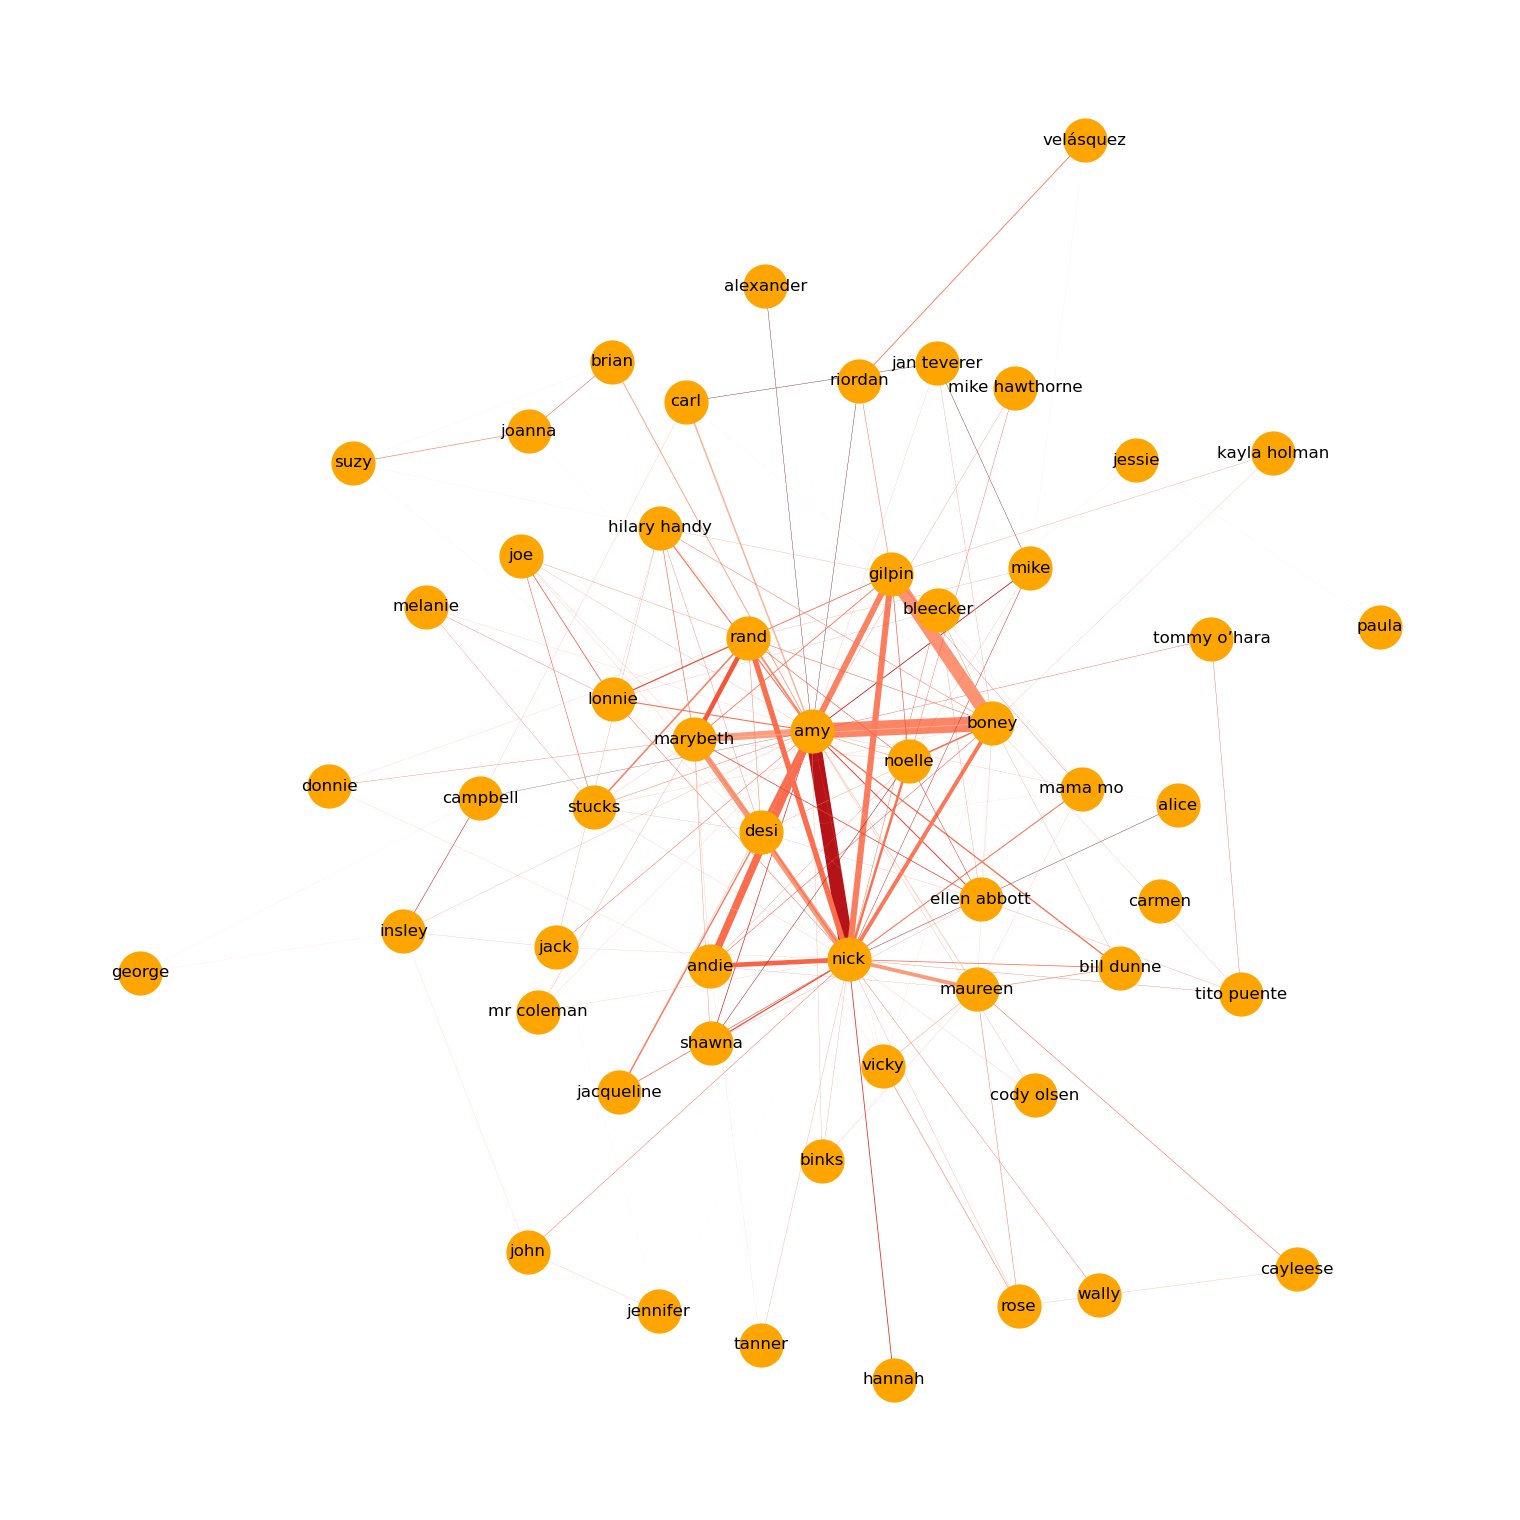

In [156]:
# change the coocurence ratio to better fit network aesthetics/readability
gg1_relationship_df['num_cooccurence'] = gg1_relationship_df['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg1_relationship_df
G = nx.from_pandas_edgelist(gg1_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

### Boy Loses Girl

To understand how character networks change in this novel, we will proceed with plotting the second part of *Gone Girl* using a similar procedure as that for the previous section.

In [132]:
# load the second part of the book and run name entity recognition on it
gg2_book = (r"C:\Users\tracypaige\LTCS180\txt_gillian_flynn\gone_girl_part2.txt")
gg2_text = open(gg2_book, encoding="utf8").read()
gg2_doc = ner(gg2_text)

In [133]:
# preview of the ner results
displacy.render(gg2_doc[0:716], style="ent", jupyter=True)

Because we've already filtered out a list of characters in the novel, we can directly continue with the character interactions.

In [134]:
gg2_char_entity_df = []

# loop through sentences, filter and store character entity list for each sentence
for sent in gg2_doc.sents:
    # make sure to filter differences by converting to lowercase
    char_entity_list = [ent.text.lower() for ent in sent.ents
                        if ent.text.lower() in list(gone_girl_characters_df['name'])]
    gg2_char_entity_df.append({"sentence": sent, "char_entities": char_entity_list})

# convert list of data into dataframe
gg2_char_entity_df = pd.DataFrame(gg2_char_entity_df)

# remove sentences without character entities
gg2_char_entity_df = gg2_char_entity_df[gg2_char_entity_df['char_entities'].map(len) > 0]

In [135]:
# let's take a look at the dataframe so far
gg2_char_entity_df.head(20)

,sentence,char_entities
10,"(But, Amy, is, afraid, of, blood, ,, the, diar...",[amy]
14,"(I, told, Nick, probably, half, a, dozen, time...",[nick]
15,"(Nick, has, such, a, careless, memory, for, ot...",[nick]
28,"(Then, I, cleaned, it, up, as, poorly, as, Nic...",[nick]
30,"(The, living, room, looks, staged, ,, yet, the...",[amy]
47,"(Item, 29, :, Say, goodbye, to, Bleecker, .)",[bleecker]
53,"(Not, Diary, Amy, ,, who, is, a, work, of, fic...",[nick]
59,"(They, were, all, girls, ;, they, were, all, n...",[hope]
60,"(I, ’m, sure, it, was, my, father, ’s, suggest...",[marybeth]
72,"(When, I, remained, alive, ,, they, named, me,...",[amy]


#### Character Network

Like before, we'll construct a character network based off of sentiment scores and number of interactions.

In [157]:
# create a relationship dataframe and print preview of results
gg2_relationship_df = pd.DataFrame(create_char_relationships(gg2_char_entity_df.reset_index()))

# assign values based on number of relationships
gg2_relationship_df["num_cooccurence"] = 1
gg2_relationship_df = gg2_relationship_df.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg2_relationship_df = gg2_relationship_df.loc[gg2_relationship_df['source'] != gg2_relationship_df['target']] 

# take a look at the character relationship dataframe
gg2_relationship_df.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,nick,-0.045381,92
1,amy,bleecker,-0.200000,2
2,bleecker,nick,-0.086503,5
3,bleecker,hope,0.285714,1
4,hope,nick,0.285714,1
5,hope,marybeth,0.930556,2
6,marybeth,nick,0.218788,13
7,amy,hope,1.111111,1
8,amy,lydia,0.581818,2
9,lydia,marybeth,0.387879,3


Now that we have this dataframe, we can construct the character network.

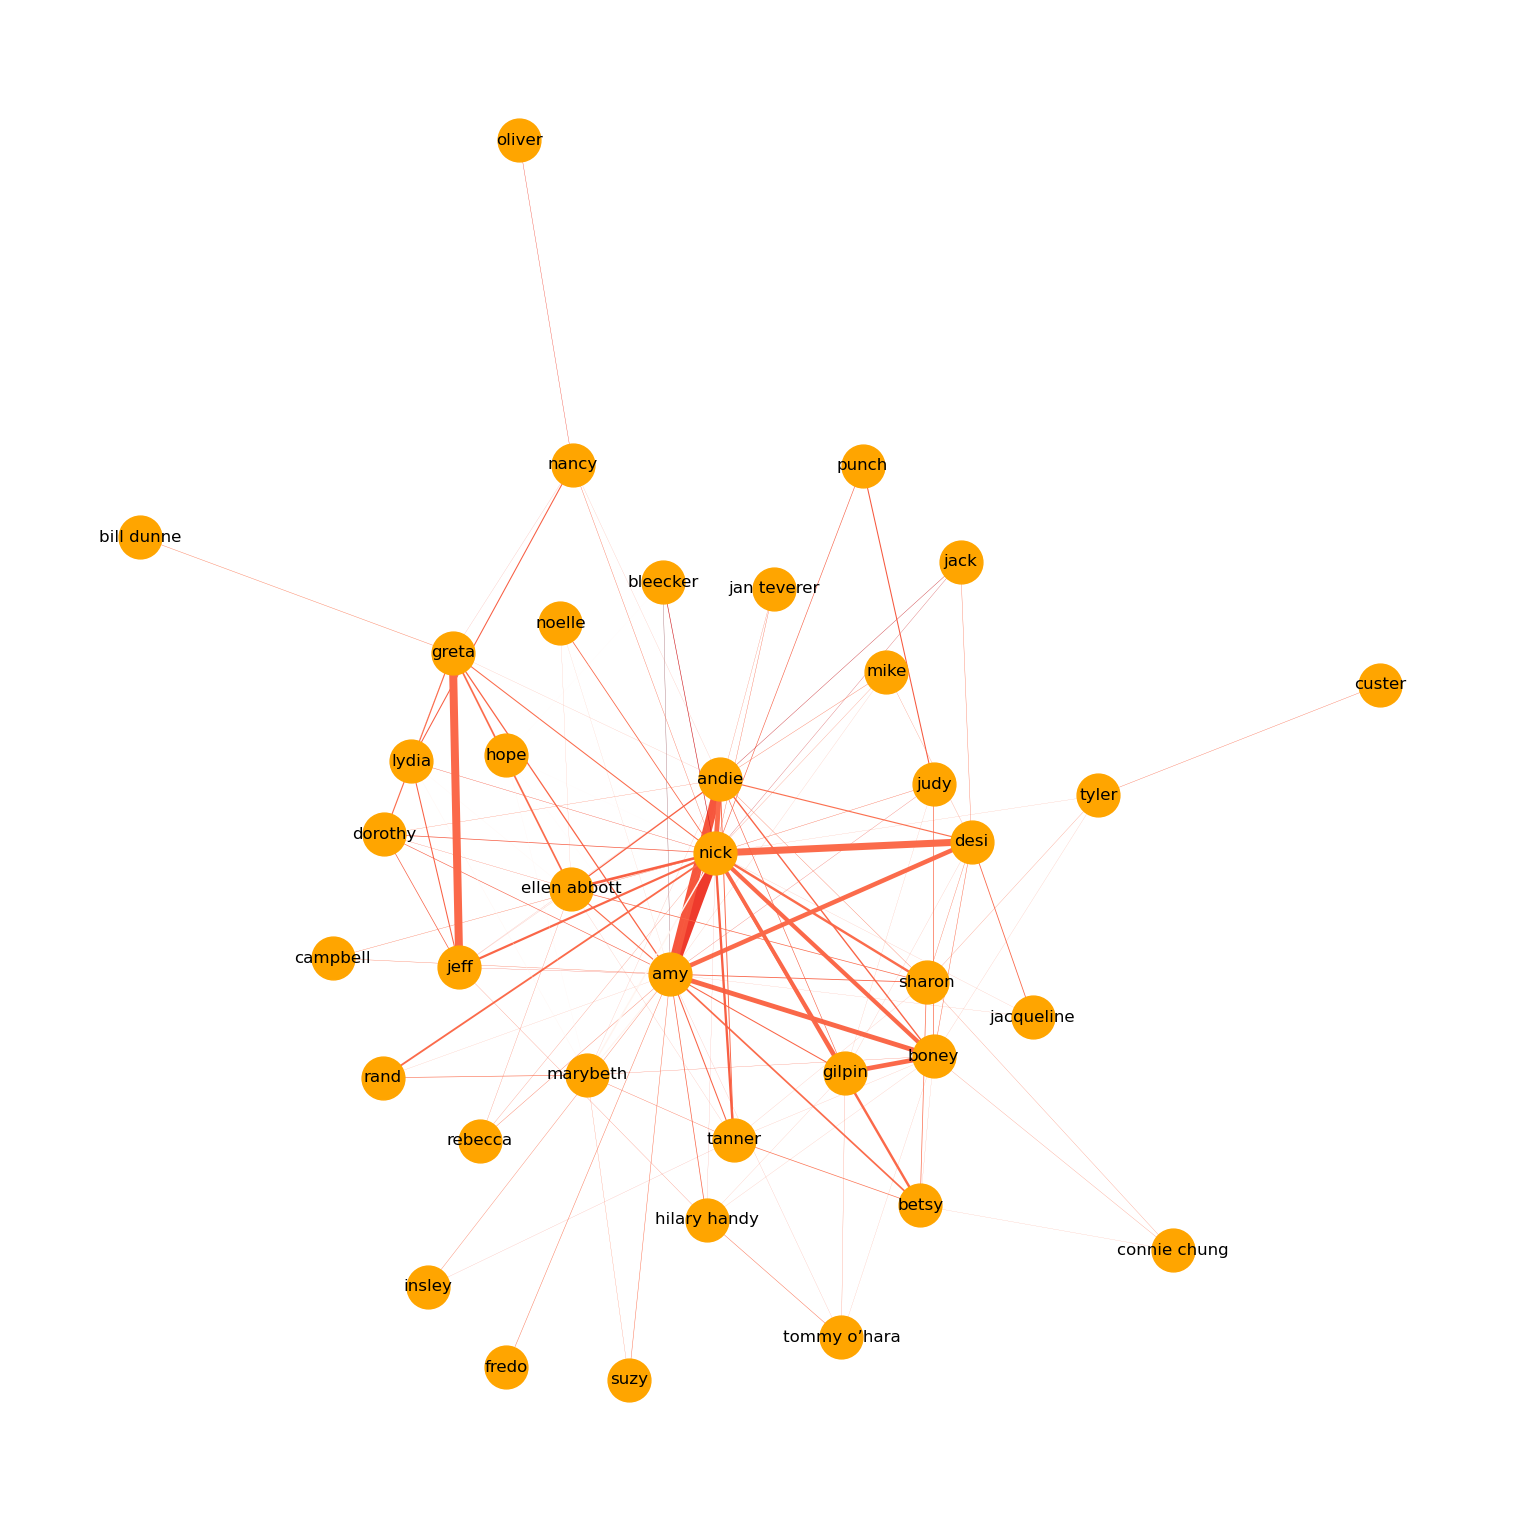

In [158]:
# change the coocurence ratio to better fit network aesthetics/readability
gg2_relationship_df['num_cooccurence'] = gg2_relationship_df['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg1_relationship_df
G = nx.from_pandas_edgelist(gg2_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.18, edge_vmax=0.18,
        width=weights)

### Boy Gets Girl Back

Finally, we will plot the last section of the novel. Again, we'll use the same procedures.

In [143]:
# load the third part of the book and run name entity recognition on it
gg3_book = (r"C:\Users\tracypaige\LTCS180\txt_gillian_flynn\gone_girl_part3.txt")
gg3_text = open(gg3_book, encoding="utf8").read()
gg3_doc = ner(gg3_text)

In [144]:
# preview of the ner results
displacy.render(gg3_doc[0:716], style="ent", jupyter=True)

Because we've already filtered out a list of characters in the novel, we can directly continue with the character interactions.

In [145]:
gg3_char_entity_df = []

# loop through sentences, filter and store character entity list for each sentence
for sent in gg3_doc.sents:
    # make sure to filter differences by converting to lowercase
    char_entity_list = [ent.text.lower() for ent in sent.ents
                        if ent.text.lower() in list(gone_girl_characters_df['name'])]
    gg3_char_entity_df.append({"sentence": sent, "char_entities": char_entity_list})

# convert list of data into dataframe
gg3_char_entity_df = pd.DataFrame(gg3_char_entity_df)

# remove sentences without character entities
gg3_char_entity_df = gg3_char_entity_df[gg3_char_entity_df['char_entities'].map(len) > 0]

In [146]:
# let's take a look at the dataframe so far
gg3_char_entity_df.head(20)

,sentence,char_entities
0,"(PART, THREE, \n\n, BOY, GETS, GIRL, BACK, \n\...",[nick]
6,"(Boney, might, have, put, a, good, word, in, f...",[boney]
17,"(Tanner, had, a, team, of, five, detectives, t...",[amy]
20,"(Every, day, for, weeks, ,, I, ’d, done, my, l...","[amy, rebecca]"
21,"((, Rebecca, ,, at, least, ,, had, remained, l...",[rebecca]
22,"(In, the, videos, ,, I, wore, clothes, Amy, ha...",[amy]
30,"(I, finished, my, evening, taping, to, Amy, .)",[amy]
31,"(I, was, wearing, a, green, shirt, she, liked,...",[amy]
35,"(Always, ending, with, Come, home, to, me, ,, ...",[amy]
61,"(The, cameras, were, blasting, us, ,, the, rep...",[amy]


#### Character Network

Like before, we'll construct a character network based off of sentiment scores and number of interactions.

In [159]:
# create a relationship dataframe and print preview of results
gg3_relationship_df = pd.DataFrame(create_char_relationships(gg3_char_entity_df.reset_index()))

# assign values based on number of relationships
gg3_relationship_df["num_cooccurence"] = 1
gg3_relationship_df = gg3_relationship_df.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg3_relationship_df = gg3_relationship_df.loc[gg3_relationship_df['source'] != gg3_relationship_df['target']] 

# take a look at the character relationship dataframe
gg3_relationship_df.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,boney,0.074015,23
1,boney,nick,0.097926,19
2,boney,rebecca,0.000000,1
3,amy,rebecca,0.411111,3
5,amy,desi,-0.027911,29
6,desi,judy,-0.030239,6
7,amy,judy,-0.152886,3
9,judy,nick,-0.000313,6
10,nick,rand,0.188170,4
12,andie,nick,0.333333,1


Now that we have this dataframe, we can construct the character network.

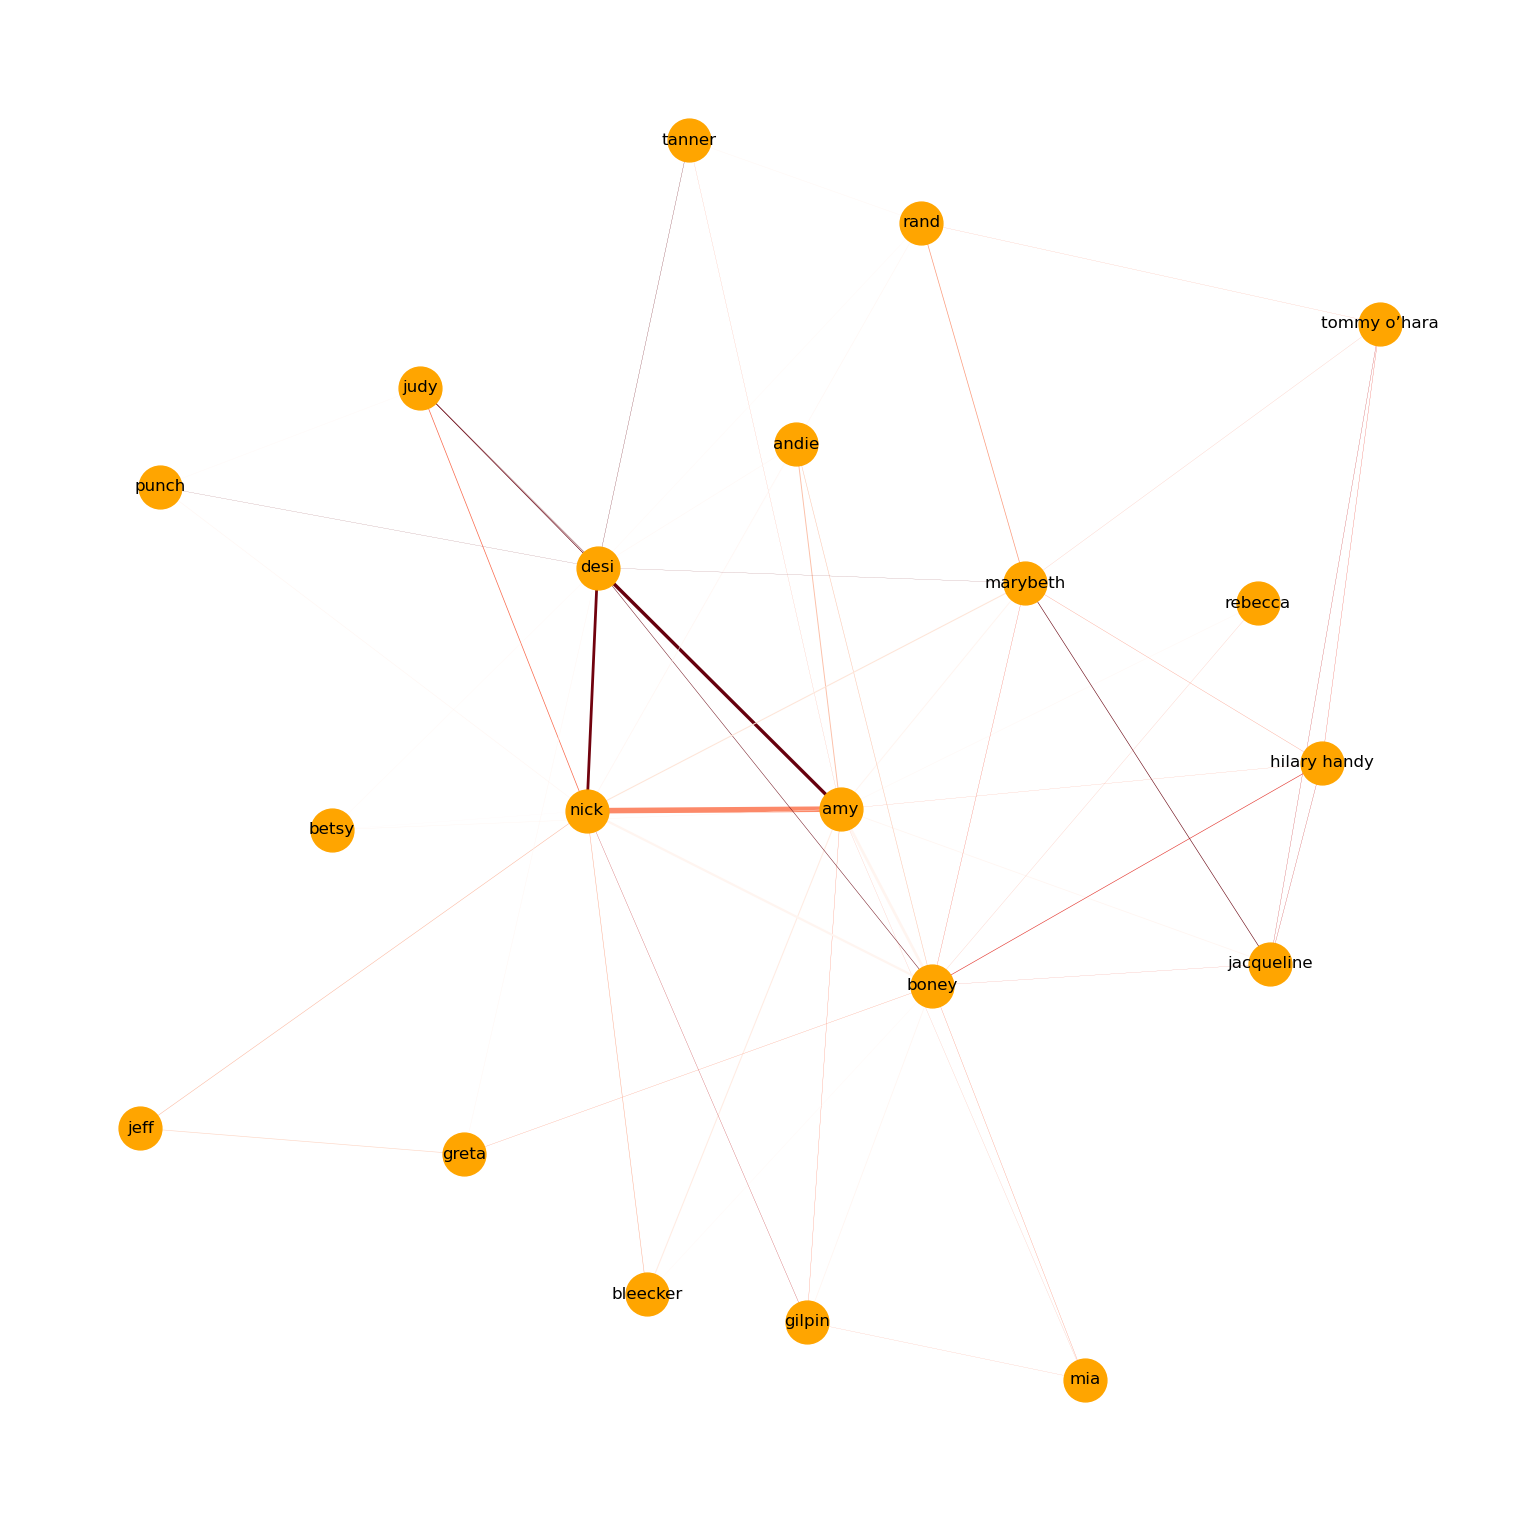

In [160]:
# change the coocurence ratio to better fit network aesthetics/readability
gg3_relationship_df['num_cooccurence'] = gg3_relationship_df['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg1_relationship_df
G = nx.from_pandas_edgelist(gg3_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

### Character Analysis

From each of the generated character networks, we can observe the characters with the most interactions seem to be:
- Part 1: Nick, Amy, Boney, Gilpin, Desi, Andie, Rand, and Marybeth
- Part 2: Nick, Amy, Boney, Gilpin, Desi, Andie, Greta, and Jeff
- Part 3: Nick, Amy, and Desi

- possList: list of nouns that the character possesses
- agentList: list of actions that the character does
- patientList: list of actions done to the character
- modList: list of words used to describe the character

In [163]:
data = proc(r"C:\Users\tracypaige\LTCS180\bookNLP_gillian_flynn\gone_girl\gone_girl.book")
character_data = create_character_data(data, 50)
df = pd.DataFrame(character_data).T.reset_index(drop=True)
df = df.sort_values(by=['timesMentioned'], ascending=False)
df.head(20)

,name,id,timesMentioned,gender,possList,agentList,patientList,modList
0,Amy,185,1977,she/her,"[(20, parents), (12, husband), (6, hair), (6, ...","[(31, said), (26, ’s), (22, want), (19, had), ...","[(13, kill), (10, love), (10, know), (8, find)...","[(11, pregnant), (6, afraid), (5, woman), (4, ..."
1,Nick,178,1937,he/him/his,"[(47, wife), (15, mom), (15, dad), (9, face), ...","[(27, said), (26, know), (21, have), (20, say)...","[(12, love), (6, framing), (5, tell), (4, ask)...","[(7, man), (4, guy), (3, angry), (3, sure), (2..."
2,Go,180,658,she/her,"[(4, beer), (4, face), (3, eyes), (2, thoughts...","[(37, said), (11, think), (9, had), (8, know),...","[(5, love), (4, tell), (3, told), (2, saw), (2...","[(1, teary), (1, slender), (1, person), (1, fi..."
3,Desi,272,617,he/him/his,"[(5, mother), (5, house), (3, eyes), (3, arm),...","[(22, said), (20, says), (12, had), (11, know)...","[(3, picture), (3, killed), (2, meet), (2, ask...","[(2, guy), (2, able), (1, figure), (1, kid), (..."
4,Boney,225,523,she/her,"[(4, head), (4, hair), (3, eyes), (3, hands), ...","[(75, said), (19, asked), (10, know), (9, look...","[(4, tell), (4, told), (4, kill), (2, met), (2...","[(1, convinced), (1, open), (1, frightened), (..."
5,Andie,324,487,she/her,"[(6, breasts), (5, face), (5, hair), (4, cheek...","[(9, said), (8, looks), (6, made), (6, know), ...","[(6, love), (3, fucked), (2, told), (2, craved...","[(4, girl), (2, young), (2, old), (2, kind), (..."
6,Tanner,359,428,he/him/his,"[(7, wife), (4, face), (4, client), (3, office...","[(43, said), (8, want), (7, ’m), (7, ’s), (7, ...","[(2, need), (1, done), (1, known), (1, see), (...","[(2, opposite), (1, successful), (1, serious),..."
7,Rand,214,265,he/him/his,"[(4, wife), (4, head), (4, eyes), (2, daughter...","[(22, said), (6, do), (6, asked), (5, put), (5...","[(3, tell), (2, told), (1, telling), (1, watch...","[(2, about), (1, host), (1, right), (1, busy),..."
8,Gilpin,194,247,he/him/his,"[(4, wife), (3, eyes), (2, lip), (1, refrigera...","[(36, said), (11, asked), (5, mean), (4, looke...","[(2, tell), (1, blame), (1, fetch), (1, drive)...","[(1, thrilled)]"
9,Greta,179,202,she/her,"[(5, legs), (2, hand), (2, mom), (2, cabin), (...","[(24, says), (3, say), (3, ’m), (3, ’s), (2, s...","[(1, saw), (1, meet), (1, told), (1, Stop), (1...","[(1, prettier), (1, silent), (1, innocent), (1..."


### Project Postmortem

- talk about where the code or data could have been bias/been innacurate